In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np



In [ ]:
# Hyperparamètres
latent_dim = 100  # Dimension du bruit aléatoire
num_classes = 10  # Nombre de classes dans MNIST (0-9)
img_size = 28  # Taille des images
channels = 1  # Canal (1 pour grayscale)
batch_size = 64
lr = 0.0002  # Taux d'apprentissage
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Dataset MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalisation entre -1 et 1
])
mnist = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True)


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.85MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.09MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Générateur
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_size, channels):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim + num_classes, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((noise, self.label_emb(labels)), -1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


# Discriminateur
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size, channels):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Linear(num_classes + int(channels * img_size ** 2), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_emb(labels)), -1)
        validity = self.model(d_in)
        return validity


In [ ]:
import torch
import torch.nn as nn

# Générateur : génère des images à partir d'un vecteur aléatoire (latent) et d'une classe donnée.
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_size, channels):
        super(Generator, self).__init__()

        # Embedding des labels (vecteur dense associé à chaque classe)
        self.label_emb = nn.Embedding(num_classes, num_classes)  # Taille num_classes pour un one-hot-like embedding

        # Taille initiale après le premier reshape (réduction de la taille spatiale)
        self.init_size = img_size // 4

        # Couche entièrement connectée pour projeter l'entrée (bruit + labels) en un tenseur spatial.
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128 * self.init_size ** 2)  # Projection dans un espace de caractéristiques initiales
        )

        # Blocs de convolutions pour augmenter la taille spatiale et affiner l'image
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),  # Normalisation des canaux pour stabiliser l'apprentissage
            nn.Upsample(scale_factor=2),  # Agrandissement de la taille spatiale (doublement)
            nn.Conv2d(128, 128, 3, stride=1, padding=1),  # Convolution pour affiner les motifs
            nn.BatchNorm2d(128, 0.8),  # Nouvelle normalisation des canaux
            nn.LeakyReLU(0.2, inplace=True),  # Activation non-linéaire pour ajouter de la complexité
            nn.Upsample(scale_factor=2),  # Deuxième agrandissement spatial
            nn.Conv2d(128, channels, 3, stride=1, padding=1),  # Convolution finale pour générer l'image finale
            nn.Tanh()  # Activation Tanh pour ramener les valeurs des pixels entre -1 et 1
        )

    def forward(self, noise, labels):
        # Concatenation du bruit et des embeddings de labels
        gen_input = torch.cat((noise, self.label_emb(labels)), -1)

        # Projection linéaire et mise en forme pour convolution
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)  # Reshape pour correspondre à une entrée convolutive

        # Passage dans les blocs convolutifs pour générer l'image
        img = self.conv_blocks(out)
        return img


# Discriminateur : classe le contenu généré comme réel ou faux (GAN classique)
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size, channels):
        super(Discriminator, self).__init__()

        # Embedding des labels pour les concaténer à l'image
        self.label_emb = nn.Embedding(num_classes, num_classes)

        # Modèle séquentiel pour classifier l'entrée image
        self.model = nn.Sequential(
            nn.Linear(num_classes + int(channels * img_size ** 2), 512),  # Combinaison image + label dans un espace latent
            nn.LeakyReLU(0.2, inplace=True),  # Activation pour capturer des motifs complexes
            nn.Linear(512, 512),  # Projection dans un espace réduit
            nn.Dropout(0.4),  # Régularisation pour éviter le surapprentissage
            nn.LeakyReLU(0.2, inplace=True),  # Activation supplémentaire
            nn.Linear(512, 1),  # Sortie unique pour la validité
            nn.Sigmoid()  # Probabilité de validité (entre 0 et 1)
        )

    def forward(self, img, labels):
        # Mise à plat de l'image et concaténation avec les embeddings des labels
        d_in = torch.cat((img.view(img.size(0), -1), self.label_emb(labels)), -1)

        # Passage dans le discriminateur
        validity = self.model(d_in)
        return validity


In [ ]:
# Initialisation des modèles
generator = Generator(latent_dim, num_classes, img_size, channels).to(device)
discriminator = Discriminator(num_classes, img_size, channels).to(device)

# Optimiseurs
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Fonction de perte
adversarial_loss = nn.BCELoss()


In [ ]:
for epoch in range(50):
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = imgs.size(0)

        # Réalités et faux labels
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # Préparer les données
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # 1. Entraîner le Générateur
        optimizer_G.zero_grad()

        # Bruit aléatoire et étiquettes aléatoires
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)

        # Générer des images
        gen_imgs = generator(z, gen_labels)

        # Calculer la perte du générateur
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)

        # Backpropagation
        g_loss.backward()
        optimizer_G.step()

        # 2. Entraîner le Discriminateur
        optimizer_D.zero_grad()

        # Perte pour les vraies images
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)

        # Perte pour les fausses images
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)

        # Perte totale du Discriminateur
        d_loss = (real_loss + fake_loss) / 2

        # Backpropagation
        d_loss.backward()
        optimizer_D.step()

        # Affichage des logs
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")


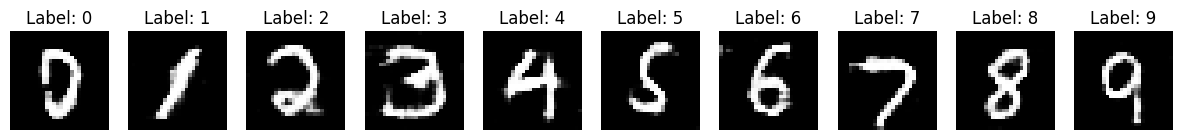

In [ ]:
import matplotlib.pyplot as plt

def generate_and_save_images(generator, num_images=10):
    z = torch.randn(num_images, latent_dim, device=device)
    labels = torch.arange(num_images, device=device)
    gen_imgs = generator(z, labels).detach().cpu()
    fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
    for i, img in enumerate(gen_imgs):
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f"Label: {labels[i].item()}")
    plt.show()

# Générer des exemples
generate_and_save_images(generator)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Hyperparamètres
latent_dim = 100
num_classes = 10  # CIFAR-10 a 10 classes
img_size = 32  # CIFAR-10 a des images de 32x32
channels = 3  # CIFAR-10 utilise des images RGB

# Transformations pour prétraiter les données
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Charger les datasets CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Modèle du générateur
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_size, channels):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, num_classes)  # Embedding pour les labels
        self.init_size = img_size // 4  # Taille après le premier reshape

        # Couche entièrement connectée pour projeter l'entrée (bruit + labels) en un tenseur spatial
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128 * self.init_size ** 2)  # Projection dans un espace de caractéristiques
        )

        # Blocs convolutifs pour augmenter la taille de l'image
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # Agrandir l'image spatialement
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, channels, 3, stride=1, padding=1),
            nn.Tanh()  # Normaliser les valeurs des pixels entre -1 et 1
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((noise, self.label_emb(labels)), -1)  # Concatenate noise et labels
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)  # Reshape pour correspondre aux convolutions
        img = self.conv_blocks(out)
        return img

# Modèle du discriminateur
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size, channels):
        super(Discriminator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, num_classes)  # Embedding pour les labels

        self.model = nn.Sequential(
            nn.Linear(num_classes + int(channels * img_size ** 2), 512),  # Combinaison image + label
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()  # Probabilité de validité entre 0 et 1
        )

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_emb(labels)), -1)  # Mise à plat et concaténation des labels
        validity = self.model(d_in)
        return validity

# Initialiser le générateur et le discriminateur
generator = Generator(latent_dim, num_classes, img_size, channels).to(device)
discriminator = Discriminator(num_classes, img_size, channels).to(device)

# Optimiseurs
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Fonction de perte
adversarial_loss = nn.BCELoss()

# Fonction d'entraînement
def train(epoch, num_epochs=100):
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size = imgs.size(0)

        # Labels réels et faux
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Envoi des images et des labels sur le GPU
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Entraîner le générateur
        optimizer_G.zero_grad()

        noise = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(noise, labels)

        g_loss = adversarial_loss(discriminator(gen_imgs, labels), real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Entraîner le discriminateur
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(imgs, labels), real_labels)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), labels), fake_labels)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Afficher les résultats toutes les 100 itérations
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(train_loader)}] "
                  f"Loss D: {d_loss.item()}, loss G: {g_loss.item()}")


# Démarrer l'entraînement
num_epochs = 100
for epoch in range(num_epochs):
    train(epoch, num_epochs)


Files already downloaded and verified
Files already downloaded and verified
Epoch [0/100] Batch [0/782] Loss D: 0.6983076333999634, loss G: 0.6793653964996338
Epoch [0/100] Batch [100/782] Loss D: 0.49126869440078735, loss G: 1.3020589351654053
Epoch [0/100] Batch [200/782] Loss D: 0.5027440786361694, loss G: 0.9941338896751404
Epoch [0/100] Batch [300/782] Loss D: 0.5828810930252075, loss G: 0.8753860592842102
Epoch [0/100] Batch [400/782] Loss D: 0.5819929838180542, loss G: 1.2668203115463257
Epoch [0/100] Batch [500/782] Loss D: 0.5775759220123291, loss G: 0.8693755865097046
Epoch [0/100] Batch [600/782] Loss D: 0.6083483695983887, loss G: 0.9921460151672363
Epoch [0/100] Batch [700/782] Loss D: 0.7204549312591553, loss G: 0.5799568891525269
Epoch [1/100] Batch [0/782] Loss D: 0.6360500454902649, loss G: 0.8545852303504944
Epoch [1/100] Batch [100/782] Loss D: 0.7423685193061829, loss G: 0.5756895542144775
Epoch [1/100] Batch [200/782] Loss D: 0.6104924082756042, loss G: 0.860808968

In [ ]:
train_dataset[3][1]

4

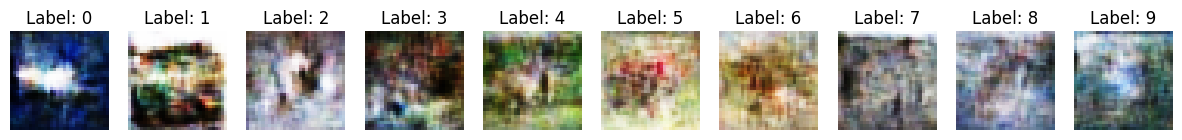

In [ ]:
def generate_and_save_images(generator, num_images=10):
    z = torch.randn(num_images, latent_dim, device=device)
    labels = torch.arange(num_images, device=device)
    gen_imgs = generator(z, labels).detach().cpu()
    fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
    for i, img in enumerate(gen_imgs):
        img = (img+1)/2
        axs[i].imshow(img.squeeze().permute(1, 2, 0))
        axs[i].axis('off')
        axs[i].set_title(f"Label: {labels[i].item()}")
    plt.show()

# Générer des exemples
generate_and_save_images(generator)


In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_size, channels):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.init_size = img_size // 4  # Réduire la taille de l'image progressivement
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256 * self.init_size ** 2)  # Plus de filtres pour plus de détails
        )

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(256),  # Augmenter le nombre de canaux
            nn.Upsample(scale_factor=2),  # Augmentation progressive de la taille
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),  # Pour des images de plus haute résolution
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh()  # Contrainte pour la plage de pixel entre -1 et 1
        )

    def forward(self, noise, labels):
        # Passer les labels dans l'Embedding, puis les ajuster en taille
        label_embeds = self.label_emb(labels)

        # Concatenate noise et label_embeds, il faut les aplatir avant la concaténation
        gen_input = torch.cat((noise, label_embeds), -1)  # Ici, on concatène le bruit et les labels dans la dimension -1

        # Passage à travers la couche linéaire
        out = self.l1(gen_input)

        # Reshape la sortie pour qu'elle corresponde aux dimensions nécessaires pour la convolution
        out = out.view(out.size(0), 256, self.init_size, self.init_size)  # Reshape pour passer à la couche suivante
        img = self.conv_blocks(out)  # Passage dans les convolutions pour générer l'image

        return img


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np



In [ ]:
latent_dim = 100  # Dimension du vecteur latent
num_classes = 40  # Nombre d'attributs dans CelebA
img_size = 128  # Taille de l'image d'entrée
channels = 3  # Nombre de canaux (images RGB)

# Transformations à appliquer sur les images
transform = transforms.Compose([
    transforms.Resize(img_size),  # Redimensionner les images
    transforms.CenterCrop(img_size),  # Recadrer l'image au format img_size x img_size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalisation entre -1 et 1
])
train_dataset = datasets.CelebA(root='./data', split='train', transform=transform, download=True)

# DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.usercontent.google.com/download?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=c9003078-b7ae-43d4-893a-bab4858789c5
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:12<00:00, 117MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /content/data/celeba/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 79.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS
To: /content/data/celeba/identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:00<00:00, 126MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pbThiMVRxWXZ4dU0
To: /content/data/celeba/list_bbox_celeba.txt
100%|██████████| 6.08M/6.08M [00:00<00:00, 191MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pd0FJY3Blby1HUTQ
To: /content/data/celeba/list_landmark

In [ ]:
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_size, channels):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)  # Embedding des labels
        self.init_size = img_size // 4  # Changed from img_size // 4 to img_size // 8
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256 * self.init_size ** 2)  # Dimension après concaténation
        )

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(256),  # Augmenter le nombre de canaux
            nn.Upsample(scale_factor=2),  # Augmentation progressive de la taille
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 64, 3, stride=1, padding=1), #removed nn.Upsample(scale_factor=2)
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh()  # Contrainte pour la plage de pixel entre -1 et 1
        )

    def forward(self, noise, labels):
        # Convertir les labels one-hot en indices

        # Passer les labels dans l'Embedding
        label_embeds = torch.matmul(labels.float(), self.label_emb.weight)  # (batch_size, num_classes)

        # Concatenate le bruit et les labels
        gen_input = torch.cat((noise, label_embeds), -1)  # Concaténation des deux dans la dernière dimension

        # Passage à travers la couche linéaire
        out = self.l1(gen_input)

        # Reshape la sortie pour qu'elle corresponde aux dimensions nécessaires pour la convolution
        out = out.view(out.size(0), 256, self.init_size, self.init_size)  # Reshape pour passer à la couche suivante
        img = self.conv_blocks(out)  # Passage dans les convolutions pour générer l'image

        return img






In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size, channels):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.channels = channels

        # Embedding des labels
        self.label_emb = nn.Embedding(num_classes, num_classes)

        # Définition du réseau
        self.model = nn.Sequential(
            nn.Conv2d(channels + num_classes, 64, 3, stride=2, padding=1),  # Concaténation sur les canaux
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(512 * (img_size // 16) * (img_size // 16), 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Convertir les labels en embeddings
        label_embeds = torch.matmul(labels.float(), self.label_emb.weight)  # Matmul des labels avec les poids de l'embedding
        print("Label embeds shape: ", label_embeds.shape)

        # Étendre les embeddings des labels pour correspondre aux dimensions de l'image
        label_embeds = label_embeds.view(label_embeds.size(0), -1, 1, 1)  # (batch_size, num_classes, 1, 1)
        label_embeds = label_embeds.expand(-1, -1, img.size(2), img.size(3))  # (batch_size, num_classes, H, W)

        # Concaténer les labels et l'image
        d_in = torch.cat((img, label_embeds), 1)  # Concaténation sur la dimension des canaux (channels)

        # Passer à travers le modèle pour obtenir la validité
        print(d_in.shape)
        validity = self.model(d_in)

        return validity


In [ ]:
# Initialisation des modèles
generator = Generator(latent_dim, num_classes, img_size, channels).to(device)
discriminator = Discriminator(num_classes, img_size, channels).to(device)

# Optimiseurs
lr = 0.0002  # Learning rate
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))  # Adam pour le générateur
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))  # Adam pour le discriminateur

# Fonction de perte
adversarial_loss = nn.BCELoss()  # Binary Cross-Entropy Loss


In [ ]:
# Boucle d'entraînement
epochs = 50  # Nombre d'époques
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(train_loader):

        batch_size = imgs.size(0)
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Créer les labels réels et faux pour la fonction de perte
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # ----------- Entraîner le générateur -----------
        optimizer_g.zero_grad()

        # Générer un vecteur latent de bruit et le concaténer avec les labels
        z = torch.randn(batch_size, latent_dim).to(device)

        gen_imgs = generator(z, labels)
        print(gen_imgs.shape)

        # Calculer la perte du générateur
        g_loss = adversarial_loss(discriminator(gen_imgs, labels), valid)
        g_loss.backward()
        optimizer_g.step()

        # ----------- Entraîner le discriminateur -----------
        optimizer_d.zero_grad()

        # Calculer la perte pour les images réelles
        real_loss = adversarial_loss(discriminator(imgs, labels), valid)

        # Calculer la perte pour les images générées
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), labels), fake)

        # Total loss du discriminateur
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_d.step()

        # Affichage des pertes
        if i % 50 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

    # Sauvegarde des images générées à chaque époque pour visualisation
    if epoch % 10 == 0:
        with torch.no_grad():
            z = torch.randn(25, latent_dim).to(device)
            labels = torch.randint(0, num_classes, (25,)).to(device)
            gen_imgs = generator(z, labels)
            gen_imgs = gen_imgs.cpu().detach().numpy()

            # Visualisation des images générées
            fig, axes = plt.subplots(5, 5, figsize=(10, 10))
            for ax, img in zip(axes.flatten(), gen_imgs):
                ax.axis('off')
                ax.imshow(np.transpose(img, (1, 2, 0)) * 0.5 + 0.5)  # Dé-normalisation
            plt.show()


torch.Size([4, 3, 128, 128])
Label embeds shape:  torch.Size([4, 40])
torch.Size([4, 43, 128, 128])
Label embeds shape:  torch.Size([4, 40])
torch.Size([4, 43, 128, 128])
Label embeds shape:  torch.Size([4, 40])
torch.Size([4, 43, 128, 128])
[Epoch 0/50] [Batch 0/40693] [D loss: 0.6934458017349243] [G loss: 0.6922383308410645]
torch.Size([4, 3, 128, 128])
Label embeds shape:  torch.Size([4, 40])
torch.Size([4, 43, 128, 128])
Label embeds shape:  torch.Size([4, 40])
torch.Size([4, 43, 128, 128])
Label embeds shape:  torch.Size([4, 40])
torch.Size([4, 43, 128, 128])


KeyboardInterrupt: 